
BANK CUSTOMER CHURN PREDICTION - COMPLETE SOLUTION
Random State: 42
Number of Folds: 10
Optuna Trials: 100
Early Stopping Rounds: 100
Loading data...
Train shape: (15000, 14)
Test shape: (10000, 13)

Target distribution:
Exited
0.0    0.797333
1.0    0.202667
Name: proportion, dtype: float64

EXPLORATORY DATA ANALYSIS

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10

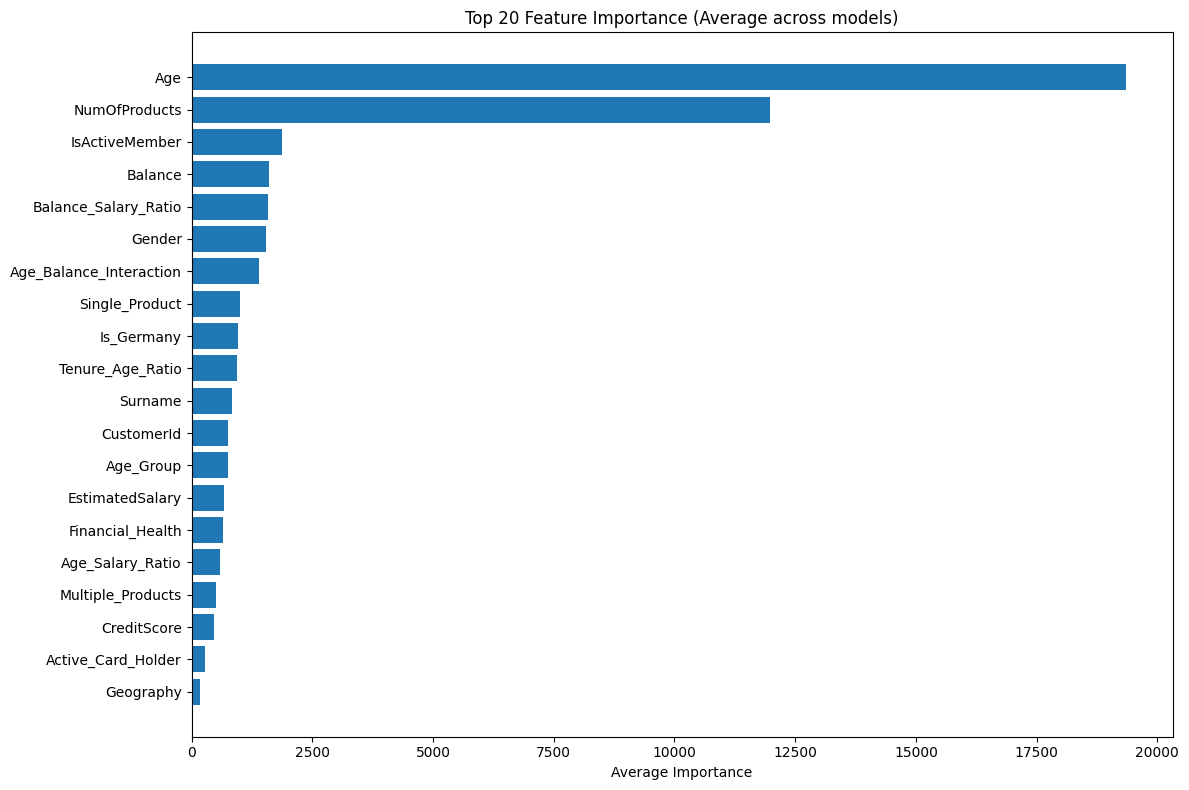

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import optuna
from optuna.samplers import TPESampler


import pickle
import json
from datetime import datetime
import gc

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

class Config:
    TRAIN_PATH = '/kaggle/input/dsc-contest-02/train.csv'
    TEST_PATH = '/kaggle/input/dsc-contest-02/test.csv'
    SUBMISSION_PATH = '/kaggle/input/dsc-contest-02/sample_submission.csv'
    OUTPUT_PATH = '/kaggle/working/'

    N_FOLDS = 10
    RANDOM_STATE = 42
    OPTUNA_TRIALS = 100
    EARLY_STOPPING_ROUNDS = 100

    APPLY_SMOTE = False 
    APPLY_FEATURE_SELECTION = True

    WEIGHTS = {
        'lgb': 0.35,
        'xgb': 0.35,
        'cat': 0.30
    }

def load_data():
    print("Loading data...")
    train = pd.read_csv(Config.TRAIN_PATH)
    test = pd.read_csv(Config.TEST_PATH)
    
    print(f"Train shape: {train.shape}")
    print(f"Test shape: {test.shape}")
    print(f"\nTarget distribution:\n{train['Exited'].value_counts(normalize=True)}")
    
    return train, test

def perform_eda(train):
    print("\n" + "="*80)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*80)
    
    # Basic info
    print("\nDataset Info:")
    print(train.info())
    
    print("\nMissing Values:")
    print(train.isnull().sum())
    
    print("\nNumerical Statistics:")
    print(train.describe())
    
    print("\nCategorical Columns:")
    categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
    print(categorical_cols)

    print(f"\nClass Distribution:")
    print(train['Exited'].value_counts())
    print(f"Churn Rate: {train['Exited'].mean():.2%}")
    
    return categorical_cols

def create_features(df, is_train=True):
    df = df.copy()
    
    print("\nCreating features...")

    if 'Age' in df.columns:
        df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 60, 100], 
                                  labels=['Young', 'Middle_Young', 'Middle', 'Senior', 'Elderly'])

    if 'CreditScore' in df.columns:
        df['CreditScore_Category'] = pd.cut(df['CreditScore'], 
                                             bins=[0, 600, 650, 700, 750, 850],
                                             labels=['Poor', 'Fair', 'Good', 'Very_Good', 'Excellent'])

    if 'Balance' in df.columns:
        df['Has_Balance'] = (df['Balance'] > 0).astype(int)
        df['Balance_Category'] = pd.cut(df['Balance'], bins=5, labels=['Very_Low', 'Low', 'Medium', 'High', 'Very_High'])
        df['Balance_Salary_Ratio'] = df['Balance'] / (df['EstimatedSalary'] + 1)

    if 'NumOfProducts' in df.columns:
        df['Single_Product'] = (df['NumOfProducts'] == 1).astype(int)
        df['Multiple_Products'] = (df['NumOfProducts'] > 2).astype(int)

    if 'IsActiveMember' in df.columns and 'HasCrCard' in df.columns:
        df['Active_Card_Holder'] = df['IsActiveMember'] * df['HasCrCard']

    if 'Tenure' in df.columns:
        df['Tenure_Age_Ratio'] = df['Tenure'] / (df['Age'] + 1)
        df['Is_New_Customer'] = (df['Tenure'] <= 2).astype(int)
        df['Is_Long_Customer'] = (df['Tenure'] >= 7).astype(int)

    if 'EstimatedSalary' in df.columns:
        df['Salary_Category'] = pd.qcut(df['EstimatedSalary'], q=5, 
                                         labels=['Very_Low', 'Low', 'Medium', 'High', 'Very_High'])
        df['Age_Salary_Ratio'] = df['Age'] / (df['EstimatedSalary'] / 10000 + 1)

    if 'Age' in df.columns and 'Balance' in df.columns:
        df['Age_Balance_Interaction'] = df['Age'] * df['Balance'] / 100000
    

    if 'Geography' in df.columns:
        df['Is_Germany'] = (df['Geography'] == 'Germany').astype(int)
        df['Is_France'] = (df['Geography'] == 'France').astype(int)
        df['Is_Spain'] = (df['Geography'] == 'Spain').astype(int)
    

    if 'Gender' in df.columns:
        df['Is_Female'] = (df['Gender'] == 'Female').astype(int)

    if all(col in df.columns for col in ['CreditScore', 'Balance', 'EstimatedSalary']):
        df['Financial_Health'] = (
            (df['CreditScore'] / 850) * 0.4 +
            (df['Balance'] / df['Balance'].max()) * 0.3 +
            (df['EstimatedSalary'] / df['EstimatedSalary'].max()) * 0.3
        )
    
    print(f"Features created. New shape: {df.shape}")
    return df

def preprocess_data(train, test):
    print("\n" + "="*80)
    print("FEATURE ENGINEERING & PREPROCESSING")
    print("="*80)

    y = train['Exited'].values
    train_ids = train['id'].values if 'id' in train.columns else None
    test_ids = test['id'].values if 'id' in test.columns else None

    X_train = train.drop(['Exited', 'id'], axis=1, errors='ignore')
    X_test = test.drop(['id'], axis=1, errors='ignore')

    X_train = create_features(X_train, is_train=True)
    X_test = create_features(X_test, is_train=False)

    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"\nCategorical columns to encode: {categorical_cols}")
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        combined = pd.concat([X_train[col], X_test[col]], axis=0)
        le.fit(combined.astype(str))
        X_train[col] = le.transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        label_encoders[col] = le

    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_test.median())
    
    print(f"\nFinal training shape: {X_train.shape}")
    print(f"Final test shape: {X_test.shape}")
    print(f"Feature names: {X_train.columns.tolist()}")
    
    return X_train, X_test, y, train_ids, test_ids, label_encoders

def train_lightgbm(X_train, y_train, X_val, y_val, params=None):
    if params is None:
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'min_child_samples': 20,
            'lambda_l1': 0.1,
            'lambda_l2': 0.1,
            'random_state': Config.RANDOM_STATE,
            'verbose': -1,
            'n_jobs': -1
        }

    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    params['scale_pos_weight'] = scale_pos_weight
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    model = lgb.train(
        params,
        train_data,
        num_boost_round=10000,
        valid_sets=[train_data, val_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=Config.EARLY_STOPPING_ROUNDS),
            lgb.log_evaluation(100)
        ]
    )
    
    return model

def train_xgboost(X_train, y_train, X_val, y_val, params=None):
    if params is None:
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 6,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_weight': 1,
            'gamma': 0.1,
            'reg_alpha': 0.1,
            'reg_lambda': 1,
            'random_state': Config.RANDOM_STATE,
            'n_jobs': -1,
            'tree_method': 'hist',
            'early_stopping_rounds': Config.EARLY_STOPPING_ROUNDS
        }

    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    params['scale_pos_weight'] = scale_pos_weight
    if 'early_stopping_rounds' not in params:
        params['early_stopping_rounds'] = Config.EARLY_STOPPING_ROUNDS
    
    model = xgb.XGBClassifier(**params, n_estimators=10000)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100
    )
    
    return model

def train_catboost(X_train, y_train, X_val, y_val, params=None):
    if params is None:
        params = {
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'iterations': 10000,
            'learning_rate': 0.05,
            'depth': 6,
            'l2_leaf_reg': 3,
            'border_count': 128,
            'random_seed': Config.RANDOM_STATE,
            'verbose': 100,
            'task_type': 'CPU',
            'thread_count': -1
        }

    class_weights = [(y_train == 0).sum() / (y_train == 1).sum(), 1.0]
    params['class_weights'] = class_weights
    
    model = cb.CatBoostClassifier(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=Config.EARLY_STOPPING_ROUNDS,
        verbose=100
    )
    
    return model

def optimize_lightgbm(X_train, y_train, n_trials=50):
    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'lambda_l1': trial.suggest_float('lambda_l1', 0, 2),
            'lambda_l2': trial.suggest_float('lambda_l2', 0, 2),
            'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 1),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'random_state': Config.RANDOM_STATE,
            'verbose': -1,
            'n_jobs': -1
        }

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=Config.RANDOM_STATE)
        auc_scores = []
        
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]
            
            scale_pos_weight = (y_tr == 0).sum() / (y_tr == 1).sum()
            params['scale_pos_weight'] = scale_pos_weight
            
            train_data = lgb.Dataset(X_tr, label=y_tr)
            val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
            
            model = lgb.train(
                params,
                train_data,
                num_boost_round=1000,
                valid_sets=[val_data],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50),
                    lgb.log_evaluation(0)
                ]
            )
            
            preds = model.predict(X_val)
            auc_scores.append(roc_auc_score(y_val, preds))
        
        return np.mean(auc_scores)
    
    print("\n" + "="*80)
    print("OPTIMIZING LIGHTGBM HYPERPARAMETERS")
    print("="*80)
    
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=Config.RANDOM_STATE)
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print(f"\nBest AUC: {study.best_value:.5f}")
    print(f"Best parameters: {study.best_params}")
    
    return study.best_params

def optimize_xgboost(X_train, y_train, n_trials=50):
    def objective(trial):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
            'random_state': Config.RANDOM_STATE,
            'n_jobs': -1,
            'tree_method': 'hist',
            'early_stopping_rounds': 50
        }

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=Config.RANDOM_STATE)
        auc_scores = []
        
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]
            
            scale_pos_weight = (y_tr == 0).sum() / (y_tr == 1).sum()
            params['scale_pos_weight'] = scale_pos_weight
            
            model = xgb.XGBClassifier(**params, n_estimators=1000)
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
            
            preds = model.predict_proba(X_val)[:, 1]
            auc_scores.append(roc_auc_score(y_val, preds))
        
        return np.mean(auc_scores)
    
    print("\n" + "="*80)
    print("OPTIMIZING XGBOOST HYPERPARAMETERS")
    print("="*80)
    
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=Config.RANDOM_STATE)
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print(f"\nBest AUC: {study.best_value:.5f}")
    print(f"Best parameters: {study.best_params}")
    
    return study.best_params

def train_with_cross_validation(X_train, y_train, X_test, optimize_hyperparams=False):
    
    print("\n" + "="*80)
    print("TRAINING WITH CROSS-VALIDATION")
    print("="*80)

    oof_preds_lgb = np.zeros(len(X_train))
    oof_preds_xgb = np.zeros(len(X_train))
    oof_preds_cat = np.zeros(len(X_train))
    
    test_preds_lgb = np.zeros(len(X_test))
    test_preds_xgb = np.zeros(len(X_test))
    test_preds_cat = np.zeros(len(X_test))

    lgb_models = []
    xgb_models = []
    cat_models = []

    best_params_lgb = None
    best_params_xgb = None
    
    if optimize_hyperparams:
        print("\nOptimizing hyperparameters (this may take a while)...")
        best_params_lgb = optimize_lightgbm(X_train, y_train, n_trials=Config.OPTUNA_TRIALS)
        best_params_xgb = optimize_xgboost(X_train, y_train, n_trials=Config.OPTUNA_TRIALS)

    skf = StratifiedKFold(n_splits=Config.N_FOLDS, shuffle=True, random_state=Config.RANDOM_STATE)
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"\n{'='*80}")
        print(f"FOLD {fold + 1}/{Config.N_FOLDS}")
        print(f"{'='*80}")
        
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        print(f"\nTrain size: {len(X_tr)}, Validation size: {len(X_val)}")
        print(f"Train churn rate: {y_tr.mean():.4f}, Val churn rate: {y_val.mean():.4f}")

        print("\n--- Training LightGBM ---")
        lgb_model = train_lightgbm(X_tr, y_tr, X_val, y_val, params=best_params_lgb)
        lgb_models.append(lgb_model)
        
        oof_preds_lgb[val_idx] = lgb_model.predict(X_val)
        test_preds_lgb += lgb_model.predict(X_test) / Config.N_FOLDS
        
        lgb_auc = roc_auc_score(y_val, oof_preds_lgb[val_idx])
        print(f"LightGBM Fold {fold + 1} AUC: {lgb_auc:.5f}")

        print("\n--- Training XGBoost ---")
        xgb_model = train_xgboost(X_tr, y_tr, X_val, y_val, params=best_params_xgb)
        xgb_models.append(xgb_model)
        
        oof_preds_xgb[val_idx] = xgb_model.predict_proba(X_val)[:, 1]
        test_preds_xgb += xgb_model.predict_proba(X_test)[:, 1] / Config.N_FOLDS
        
        xgb_auc = roc_auc_score(y_val, oof_preds_xgb[val_idx])
        print(f"XGBoost Fold {fold + 1} AUC: {xgb_auc:.5f}")

        print("\n--- Training CatBoost ---")
        cat_model = train_catboost(X_tr, y_tr, X_val, y_val)
        cat_models.append(cat_model)
        
        oof_preds_cat[val_idx] = cat_model.predict_proba(X_val)[:, 1]
        test_preds_cat += cat_model.predict_proba(X_test)[:, 1] / Config.N_FOLDS
        
        cat_auc = roc_auc_score(y_val, oof_preds_cat[val_idx])
        print(f"CatBoost Fold {fold + 1} AUC: {cat_auc:.5f}")

        oof_ensemble = (
            Config.WEIGHTS['lgb'] * oof_preds_lgb[val_idx] +
            Config.WEIGHTS['xgb'] * oof_preds_xgb[val_idx] +
            Config.WEIGHTS['cat'] * oof_preds_cat[val_idx]
        )
        ensemble_auc = roc_auc_score(y_val, oof_ensemble)
        print(f"Ensemble Fold {fold + 1} AUC: {ensemble_auc:.5f}")

        gc.collect()

    print("\n" + "="*80)
    print("OVERALL CROSS-VALIDATION RESULTS")
    print("="*80)
    
    lgb_cv_auc = roc_auc_score(y_train, oof_preds_lgb)
    xgb_cv_auc = roc_auc_score(y_train, oof_preds_xgb)
    cat_cv_auc = roc_auc_score(y_train, oof_preds_cat)
    
    oof_ensemble = (
        Config.WEIGHTS['lgb'] * oof_preds_lgb +
        Config.WEIGHTS['xgb'] * oof_preds_xgb +
        Config.WEIGHTS['cat'] * oof_preds_cat
    )
    ensemble_cv_auc = roc_auc_score(y_train, oof_ensemble)
    
    print(f"\nLightGBM CV AUC: {lgb_cv_auc:.5f}")
    print(f"XGBoost CV AUC: {xgb_cv_auc:.5f}")
    print(f"CatBoost CV AUC: {cat_cv_auc:.5f}")
    print(f"Ensemble CV AUC: {ensemble_cv_auc:.5f}")

    test_preds_ensemble = (
        Config.WEIGHTS['lgb'] * test_preds_lgb +
        Config.WEIGHTS['xgb'] * test_preds_xgb +
        Config.WEIGHTS['cat'] * test_preds_cat
    )

    models = {
        'lgb': lgb_models,
        'xgb': xgb_models,
        'cat': cat_models
    }
    
    predictions = {
        'oof_lgb': oof_preds_lgb,
        'oof_xgb': oof_preds_xgb,
        'oof_cat': oof_preds_cat,
        'oof_ensemble': oof_ensemble,
        'test_lgb': test_preds_lgb,
        'test_xgb': test_preds_xgb,
        'test_cat': test_preds_cat,
        'test_ensemble': test_preds_ensemble
    }
    
    return models, predictions, {
        'lgb_auc': lgb_cv_auc,
        'xgb_auc': xgb_cv_auc,
        'cat_auc': cat_cv_auc,
        'ensemble_auc': ensemble_cv_auc
    }

def plot_feature_importance(models, X_train, top_n=20):
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)

    lgb_importance = models['lgb'][0].feature_importance(importance_type='gain')
    xgb_importance = models['xgb'][0].feature_importances_
    cat_importance = models['cat'][0].feature_importances_

    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'lgb': lgb_importance,
        'xgb': xgb_importance,
        'cat': cat_importance
    })

    importance_df['avg_importance'] = importance_df[['lgb', 'xgb', 'cat']].mean(axis=1)
    importance_df = importance_df.sort_values('avg_importance', ascending=False)
    
    print(f"\nTop {top_n} Most Important Features:")
    print(importance_df.head(top_n))

    plt.figure(figsize=(12, 8))
    plt.barh(range(top_n), importance_df['avg_importance'].head(top_n))
    plt.yticks(range(top_n), importance_df['feature'].head(top_n))
    plt.xlabel('Average Importance')
    plt.title(f'Top {top_n} Feature Importance (Average across models)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(Config.OUTPUT_PATH + 'feature_importance.png', dpi=300, bbox_inches='tight')
    print(f"\nFeature importance plot saved to: {Config.OUTPUT_PATH}feature_importance.png")
    
    return importance_df

def save_checkpoint(models, predictions, scores, X_train):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    checkpoint_dir = Config.OUTPUT_PATH + f'checkpoint_{timestamp}/'
    
    import os
    os.makedirs(checkpoint_dir, exist_ok=True)

    with open(checkpoint_dir + 'models.pkl', 'wb') as f:
        pickle.dump(models, f)

    np.save(checkpoint_dir + 'predictions.npy', predictions)

    with open(checkpoint_dir + 'scores.json', 'w') as f:
        json.dump(scores, f, indent=4)

    with open(checkpoint_dir + 'feature_names.json', 'w') as f:
        json.dump(X_train.columns.tolist(), f)
    
    print(f"\nCheckpoint saved to: {checkpoint_dir}")
    
    return checkpoint_dir

def create_submission(test_ids, predictions, filename='submission.csv'):
    submission = pd.DataFrame({
        'id': test_ids,
        'Exited': predictions
    })
    
    submission_path = Config.OUTPUT_PATH + filename
    submission.to_csv(submission_path, index=False)
    
    print("\n" + "="*80)
    print("SUBMISSION CREATED")
    print("="*80)
    print(f"\nSubmission saved to: {submission_path}")
    print(f"Submission shape: {submission.shape}")
    print("\nFirst few predictions:")
    print(submission.head(10))
    print("\nPrediction statistics:")
    print(submission['Exited'].describe())
    
    return submission

def main():

    print("\n" + "="*80)
    print("BANK CUSTOMER CHURN PREDICTION - COMPLETE SOLUTION")
    print("="*80)
    print(f"Random State: {Config.RANDOM_STATE}")
    print(f"Number of Folds: {Config.N_FOLDS}")
    print(f"Optuna Trials: {Config.OPTUNA_TRIALS}")
    print(f"Early Stopping Rounds: {Config.EARLY_STOPPING_ROUNDS}")

    train, test = load_data()

    categorical_cols = perform_eda(train)

    X_train, X_test, y_train, train_ids, test_ids, label_encoders = preprocess_data(train, test)

    models, predictions, scores = train_with_cross_validation(
        X_train, y_train, X_test, 
        optimize_hyperparams=False 
    )

    importance_df = plot_feature_importance(models, X_train, top_n=20)
    
    checkpoint_dir = save_checkpoint(models, predictions, scores, X_train)

    create_submission(test_ids, predictions['test_lgb'], 'submission_lgb.csv')
    create_submission(test_ids, predictions['test_xgb'], 'submission_xgb.csv')
    create_submission(test_ids, predictions['test_cat'], 'submission_cat.csv')
    create_submission(test_ids, predictions['test_ensemble'], 'submission_ensemble.csv')
    
    print("\n" + "="*80)
    print("EXECUTION COMPLETED SUCCESSFULLY!")
    print("="*80)
    print(f"\nFinal Ensemble CV AUC: {scores['ensemble_auc']:.5f}")
    print(f"\nCheckpoint directory: {checkpoint_dir}")
    print("\nSubmission files created:")
    print("  - submission_lgb.csv")
    print("  - submission_xgb.csv")
    print("  - submission_cat.csv")
    print("  - submission_ensemble.csv (RECOMMENDED)")

if __name__ == "__main__":
    main()

In [2]:
import os
import glob
import subprocess
import shutil
from datetime import datetime
from kaggle_secrets import UserSecretsClient

GITHUB_USERNAME = "Zalanemoj"
GITHUB_REPO = "DSC-Bi-Weekly-Challenge"
GITHUB_EMAIL = "zalanemoj777@gmail.com"
GITHUB_DIR = "Outputs_DSC#2"
BRANCH = "main"

FILE_PATTERNS = ["*.csv", "*.png", "*.jpg", "*.json"]

user_secrets = UserSecretsClient()
TOKEN = user_secrets.get_secret("GITHUB_TOKEN")
REPO_URL = f"https://{TOKEN}@github.com/{GITHUB_USERNAME}/{GITHUB_REPO}.git"

work_dir = "/kaggle/working/git_temp"
source_dir = "/kaggle/working"

if os.path.exists(work_dir):
    shutil.rmtree(work_dir)

os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)

subprocess.run(["git", "config", "--global", "user.email", GITHUB_EMAIL], check=True, capture_output=True)
subprocess.run(["git", "config", "--global", "user.name", GITHUB_USERNAME], check=True, capture_output=True)

subprocess.run(["git", "init"], check=True, capture_output=True)
subprocess.run(["git", "remote", "add", "origin", REPO_URL], check=True, capture_output=True)

pull_result = subprocess.run(["git", "pull", "origin", BRANCH], capture_output=True, text=True)

if pull_result.returncode != 0:
    subprocess.run(["git", "checkout", "-b", BRANCH], capture_output=True)

target_dir = os.path.join(work_dir, GITHUB_DIR)
os.makedirs(target_dir, exist_ok=True)

os.chdir(source_dir)
files_copied = []

for pattern in FILE_PATTERNS:
    for file in glob.glob(pattern):
        if os.path.isfile(file):
            shutil.copy2(file, target_dir)
            files_copied.append(file)
            print(f"✓ {file}")

print(f"\nCopied {len(files_copied)} files to {GITHUB_DIR}/")

os.chdir(work_dir)

subprocess.run(["git", "add", "-A"], check=True, capture_output=True)

commit_msg = f"Update {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
commit_result = subprocess.run(["git", "commit", "-m", commit_msg], capture_output=True, text=True)

if commit_result.returncode == 0 or files_copied:
    print(f"Committing changes...")
    
    subprocess.run(["git", "branch", "-M", BRANCH], check=True, capture_output=True)
    
    push_result = subprocess.run(["git", "push", "-u", "origin", BRANCH], capture_output=True, text=True)
    
    if push_result.returncode != 0:
        print("Regular push failed, trying force push...")
        force_result = subprocess.run(["git", "push", "-f", "-u", "origin", BRANCH], capture_output=True, text=True)
        if force_result.returncode == 0:
            print(f"✅ Force pushed {len(files_copied)} files")
        else:
            print(f"❌ Push failed: {force_result.stderr}")
    else:
        print(f"✅ Pushed {len(files_copied)} files")
    
    print(f"View at: https://github.com/{GITHUB_USERNAME}/{GITHUB_REPO}/tree/{BRANCH}/{GITHUB_DIR}")
else:
    print("No changes detected")

os.chdir(source_dir)

✓ submission_xgb.csv
✓ submission_ensemble.csv
✓ submission_lgb.csv
✓ submission_cat.csv
✓ feature_importance.png

Copied 5 files to Outputs_DSC#2/
Committing changes...
✅ Pushed 5 files
View at: https://github.com/Zalanemoj/DSC-Bi-Weekly-Challenge/tree/main/Outputs_DSC#2


In [3]:
import os
import glob
import subprocess
import shutil
from datetime import datetime
from kaggle_secrets import UserSecretsClient

GITHUB_USERNAME = "Zalanemoj"
GITHUB_REPO = "DSC-Bi-Weekly-Challenge"
GITHUB_EMAIL = "zalanemoj777@gmail.com"
GITHUB_DIR = "Outputs_DSC#2"
BRANCH = "main"

FILES_TO_PUSH = ["*.csv", "*.png", "*.jpg", "*.json","*.pkl"]
FOLDERS_TO_PUSH = ["*"]

TOKEN = UserSecretsClient().get_secret("GITHUB_TOKEN")
REPO_URL = f"https://{TOKEN}@github.com/{GITHUB_USERNAME}/{GITHUB_REPO}.git"

source = "/kaggle/working"
temp = "/kaggle/working/git_temp"

if os.path.exists(temp):
    shutil.rmtree(temp)
os.makedirs(temp)

os.chdir(temp)
subprocess.run(["git", "init"], capture_output=True)
subprocess.run(["git", "config", "user.email", GITHUB_EMAIL], capture_output=True)
subprocess.run(["git", "config", "user.name", GITHUB_USERNAME], capture_output=True)
subprocess.run(["git", "remote", "add", "origin", REPO_URL], capture_output=True)
subprocess.run(["git", "pull", "origin", BRANCH], capture_output=True)

target = os.path.join(temp, GITHUB_DIR)
os.makedirs(target, exist_ok=True)
IGNORE_FOLDERS = ["git_temp", ".virtual_documents", ".git"]
os.chdir(source)

print("Copying files:")
for pattern in FILES_TO_PUSH:
    for item in glob.glob(pattern):
        shutil.copy2(item, target)
        print(f"  ✓ {item}")

print("\nCopying folders:")
for pattern in FOLDERS_TO_PUSH:
    for folder in glob.glob(pattern):
        if any(ignored in folder for ignored in IGNORE_FOLDERS):
            continue

        if os.path.isdir(folder):
            dest = os.path.join(target, folder)
            if os.path.exists(dest):
                shutil.rmtree(dest)
            shutil.copytree(folder, dest)
            print(f"  ✓ {folder}/")

os.chdir(temp)
subprocess.run(["git", "add", "-A"], capture_output=True)
subprocess.run(["git", "commit", "-m", f"Update {datetime.now().strftime('%Y-%m-%d %H:%M')}"], capture_output=True)
subprocess.run(["git", "branch", "-M", BRANCH], capture_output=True)

result = subprocess.run(["git", "push", "-f", "origin", BRANCH], capture_output=True, text=True)

if result.returncode == 0:
    print(f"\n✅ Success! https://github.com/{GITHUB_USERNAME}/{GITHUB_REPO}/tree/{BRANCH}/{GITHUB_DIR}")
else:
    print(f"\n❌ Failed: {result.stderr}")

os.chdir(source)

Copying files:
  ✓ submission_xgb.csv
  ✓ submission_ensemble.csv
  ✓ submission_lgb.csv
  ✓ submission_cat.csv
  ✓ feature_importance.png

Copying folders:
  ✓ catboost_info/
  ✓ checkpoint_20260116_173605/

✅ Success! https://github.com/Zalanemoj/DSC-Bi-Weekly-Challenge/tree/main/Outputs_DSC#2
